## Pose model evaluation

This notebook uses the MARSeval module from https://github.com/neuroethology/MARS_pycocotools to evaluate a trained pose model in terms of a few commonly used computer vision metrics, including the **Object Keypoint Similarity** (OKS) and **Percent Correct Keypoints** (PCK).

In [1]:
%matplotlib inline

from evaluation import evaluation
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Evaluating model performance on the test set

Before we can quantify performance, we have to run our trained model on the held-out test set. We do this using `run_test`, which takes optional arguments:
* `pose_model_names`, the subset of models to evaluate (defaults to all.)
* `num_images`, the number of images in the test set to evaluate on (defaults to all.)

It also returns an object `performance` that we can use to generate some figures.

In [ ]:
from hourglass_pose import evaluate_pose

project_path = 'D:\my_project'
performance = evaluate_pose.run_test(project_path)

`performance` is a dictionary of `cocoEval` objects- one for each body part, and one pooling across all parts.

We can use the `performance` object to evaluate the accuracy of our model. To do so, we'll make use of the [`MARSeval`](https://github.com/neuroethology/MARS_pycocotools) module, which is based on the popular [CoCo API](https://github.com/cocodataset/cocoapi) for evaluation of computer vision models.

Once you've called `run_test` once, you can quickly re-generate `performance` by calling:

In [ ]:
performance = evaluate_pose.coco_eval(project_path)

### Object-keypoint similarity (OKS)

The Object-Keypoint Similarity (OKS) is a measure of pose accuracy that normalizes performance by the estimated variance of human annotators:
![OKS summary](https://github.com/neuroethology/MARS_pycocotools/raw/master/docs/keypoint_similarity.png)

In the human pose estimation literature, OKS values are typically summarized in terms of the Mean average precision (mAP) and Mean average recall (mAR). To understand these terms, we must first talk about confidence, precision, and recall.

In machine learning, **Precision** is computed as **True Positives / (True Positives + False Positives)**, while **Recall** is **True Positives / True Positives + False Negatives**. For pose estimation, a True Positive is clear: it's when a keypoint is detected falls within some "permissible radius" $R$ of the ground truth. But what makes a False Positive vs a False Negative?

MARS keypoint predictions have a **location** $(x,y)$ as well as a **confidence** $s$- the latter reflects the model's certainty that a keypoint is indeed detected at the provided location. (MARS's pose model will return keypoint locations regardless of confidence, however low confidence is often a good indicator that those locations will be bad.) We will therefore call a keypoint a False Positive if confidence is above some threshold $C$ but location is far from ground truth, and a False Negative otherwise. Because there is always a ground truth keypoint location (even when occluded), there is no True Negative category.

Given fixed permissible radius $R$, we can therefore plot Precision-Recall curves as one would for a classifier: by plotting Precision vs Recall as we gradually lower the confidence threshold $C$. We summarize this plot by taking the approximate area under the P-R curve, a value called the **Average Precision** (AP). Alternatively, we can report the fraction of True Positive detections if any confidence score is accepted- this is called the **Average Recall** (AR).

The last piece in the puzzle is our choice of permissible radius $R$: how close does a predicted keypoint have to be to ground truth to count as correct? And with what units? For units, we will use our previously defined OKS, which ranges from 0 (poor) to 1 (perfect). As for choice of $R$, the accepted approach in machine learning is to simply recompute the AP and AR for a range of values of $R$-- specifically, $R = \{0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95\}$, and then to take the mean value of AP and AR across these 10 values: hence, the **mean Average Precision** and **mean Average Recall**.

To compute the OKS with a different value of $\sigma$, we must first re-generate `performance` with additional arguments:

* Calling `evaluation.coco_eval` with additional argument `view=top` or `view=front` computes OKS using estimates of human annotator variability ($\sigma$) for all keypoints in the MARS dataset (nose tip, right/left ear, neck, right/left side body, and tail base), calculated from the original 15,000-frame MARS pose dataset.
* Calling `evaluation.coco_eval(fid, fixedSigma='narrow')` computes OKS using a fixed value of $\sigma$ for all keypoints: available values are narrow ($\sigma = 0.025$), moderate ($\sigma = 0.05$), wide ($\sigma = 0.1$), and ultrawide ($\sigma = 0.15$).

By default, OKS is computed using the `fixedSigma='narrow'` setting: we'll look at that first.

Once you have `performance`, the OKS metric is quick to generate- our `cocoEval` objects inside `performance` have a built-in method to output OKS mAP and mAR values to terminal:

#### `performance[part].summarize()`

#### Input
* `part` is the part we want performance for- either "all" or the name of a specific body part.

#### Output

* **Mean average precision (mAP)** computed for all keypoints in the category `part.
* **Mean average recall (mAR)** computed for all keypoints in the category `part.

In [4]:
for part in performance.keys():
    print('Performance for keypoint: ' + part + ' ---' if part!='all' else 'Mean performance across keypoints ---')
    performance[part].summarize()
    print('')

Mean performance across keypoints ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.835

Performance for keypoint: nose tip ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.819

Performance for keypoint: right ear ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.848

Performance for keypoint: left ear ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.848

Performance for keypoint: neck ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.858

Perf

### OKS histograms

It can also be useful to look at a histogram of OKS values across all images in the test set. We can produce one using: 

#### `evaluation.compute_oks_histogram`

#### Inputs
* One of the `cocoEval` objects stored in `performance`.

#### Outputs
* `counts` and `bins` for a histogram of OKS values.

Text(0.5, 0, 'OKS')

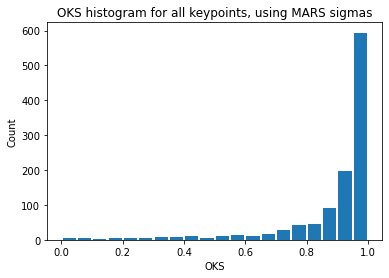

In [5]:
usePart = 'all' # the part we're going to look at (or use 'all' to look at mean across body parts)

# compute counts for histogram of OKS values.
counts, bins = evaluation.compute_oks_histogram(performance[usePart])

# and take a look:
binSize = 0.9/len(bins)
plt.bar((bins[1:]+bins[:-1])/2, counts, binSize);
plt.title('OKS histogram for ' + ('all keypoints' if usePart == 'all' else usePart) + ', using narrow sigmas')
plt.ylabel('Count')
plt.xlabel('OKS')

### Choice of $\sigma$, revisited

Now that you know what $\sigma$ is, let's repeat the analysis above with a fixed, narrow $\sigma$, and look at our two histograms of OKS values side-by-side to see the difference.

In [6]:
performance_MARS = evaluation.coco_eval(fid,view='top')

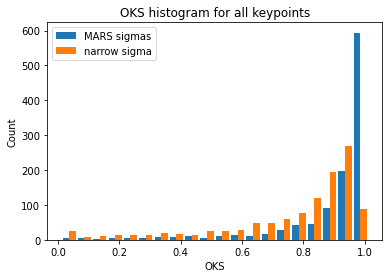

In [7]:
usePart = 'all'

counts_MARS, _ = evaluation.compute_oks_histogram(performance_MARS[usePart])

binSize = 0.45/len(bins)
plt.bar((bins[1:]+bins[:-1])/2, counts_MARS, binSize)
plt.bar((bins[1:]+bins[:-1])/2+binSize, counts, binSize)
plt.title('OKS histogram for ' + ('all keypoints' if usePart == 'all' else usePart))
plt.ylabel('Count')
plt.xlabel('OKS')
plt.legend(('MARS sigmas', 'narrow sigma'))

### Percent Correct Keypoints (PCK)

We can also evaluate our pose model in terms of the percent of time estimated keypoints fall within a radius $X$ of ground truth, for a range values of $X$. This is called the Percent Correct Keypoints (PCK). `plot_model_PCK` takes arguments:

* `pose_model_names` specifies which models to generates plots for (defaults to all.)
* `xlim` is a two-element list specifying the min and max bounds of the x axis for all subplots.
* `pixel_units=True` plots in units of pixels instead of cm.
* `combine_animals=True` pools human annotation data across animal types in your dataset. Model performance plots are always pooled (to be fixed later.)


In [ ]:
import evaluate_pose

project_path = 'D:\my_project'
evaluate_pose.plot_model_PCK(project_path, combine_animals=True)